# BERT Narration Classification

### Final Project - Vincent Gu
### DATASCI 266 - Section 3 - Summer 2023

## Background

As a model framework, BERT's pre-training on existing 'real' data such as Wikipedia provides an enormous repository
of context and position based word embeddings suitable as a starting point for a myriad of language tasks. Tuning this 
pre-trained model can lead to increased task accuracy for specific tasks and datasets.

However, how does BERT perform when presented with fictional text that differs substantially from the non-fiction
(Wikipedia) data it was trained on? Furthermore, how well can BERT be fine-tuned with fictional text to increase 
performance at a classification text? Finally, how well can BERT pick up subtle variations in word meanings based on 
surrounding fictional context?

To begin answering these questions, I leveraged the base BERT model with the science fiction novel 'Dark Age' by 
Pierce Brown. In the novel Brown crafts a dystopia in which mankind genetically engineered itsself into twelve distinct castes (colors in the book). Each color holds a certain function in society and inter-color marriage is forbidden and engineered to be biologically impossible. For example, Gold as the ruling class are engineered to be taller, stronger and smarter than Reds who toil as menial slave laborers.

The novel contains narration from 5 different individuals of different colors and perspectives and the corresponding language task involves classifying an excerpt of the text based on which narrator the model believes the text came 
from. I then looked to improve model performance by fine-tuning. Finally, I analyzed various out-of-context words 
specific to the world Pierce Brown created to determine if the fine-tuned BERT could pick up nuanced word meanings,
as represented in word embeddings, based on narrator.

The five narrators (classification buckets) are:
1. Darrow: A Red genetically 'carved' into a Gold warlord who led an uprising
2. Virginia: The Gold Sovereign (ruler) of a more egalitarian/reformed society
3. Ephraim: A Gray (foot soldier)
4. Lyria: A Red disillusioned with Virginia's society
5. Lysander: The last grandchild of the former Sovereign, a fascist slaver

## Objectives

- Build and train a fine-tuned BERT model to classify excerpts from the novel based on its narrator
- Determine if the model can pick up nuanced out-of-context word meanings based on the perspectives of each narrator

## Project Directory

* data (directory)
  * dark-age-raw-text.txt
* helpermodule (directory)
  * data.py
* models (directory - not in Github due to model size)
* **main.ipynb**
* BERT_base.py
* train_BERT_base.sh

## Data Setup

In [1]:
import sys
sys.path.append('helpermodule')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
from numpy import dot
from numpy.linalg import norm

from helpermodule import data
from data import get_chapter_data, get_excerpt_data, format_data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

The custom helpermodule package processes the raw text into labeled data. We have 2,214 excerpts of 128 words. Here is an example of the label associated with a given excerpt. 

In [2]:
excerpt_labels, excerpt_examples = get_excerpt_data(n_words=128)
print("# Excerpts:", len(excerpt_labels))
print(excerpt_labels[2000])
print(excerpt_examples[2000])

# Excerpts: 2214
Darrow
wheel away back into my world. The Reds who came to my aid stand watching me. There are six of the sunbaked laborers. Not a one older than twenty. They stand with their ﬁsts in a salute. I open an external pouch manually and ﬁnd the helm key. I insert it into the collar until a latch pops. I roll back the wolf’s head helm and suck down the fresh air. The young Reds stare up at me. They might have thought they recognized my armor before, but now they see my face, and they take a step back in fear. “I lost my razor on the rooftops. Find it.” By the time the skinniest of them returns with my slingBlade in his trembling hands, another crowd has


How balanced are our classes?

For the most part, relatively balanced. But the 'Ephraim' and 'Virginia' narrations aren't quite as prevalent as 'Lysander'.

In [3]:
np.unique(excerpt_labels, return_counts=True)

(array(['Darrow', 'Ephraim', 'Lyria', 'Lysander', 'Virginia'], dtype='<U8'),
 array([456, 458, 367, 556, 377]))

# BERT Setup

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.utils import to_categorical
import seaborn as sns

import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from transformers import logging
tf.get_logger().setLevel('ERROR')

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Training the Fine-Tuned Models

To gauge various model training behaviors, the fine-tuned BERT model was trained using a number of batch sizes: **4, 8, 16** and two excerpt sizes: **64, 128**. In this setting, a single labeled observation (data point) would be comprised of either 100 or 256 words. Training details are saved as screenshots under the **training_screenshots** folder.

As BERT's underlying transformer architecture requires significant computational resources, models were trained using GPU as opposed to CPU. Attempting to train on CPU look approximately two hours per epoch which was cut to between 5-10 minutes per epoch with GPU. Due to the size of these models, they were trained via commandline with the shell script **train_BERT.sh** which makes sucessive calls to **BERT_base.py**. These individual .py calls are parameterized with both the batch size and excerpt size. 

The three BERT inputs of input ids, token type ids and attention mask are consolidated into the [CLS] token embedding which is then fed into successive fully connected dense layers and a final five-class softmax classification output layer.

Overall, the models were able to learn a significant amount during training with final epoch validation accuracies around 80%. We see in initial epochs many models start off with about 20% validation accuracy - which indicates that at this point the model isn't performing any better at sorting into the five bins than it would if it was just randomly guessing. However, the substantial increases in validation accuracy over epochs demonstrates BERT's ability to learn.

*Best Performing Model*

In [6]:
bert_model_ft = tf.keras.models.load_model('./models/bert_classification_model_16_100.h5', custom_objects={"TFBertModel": bert_model})
x_train, x_test, y_train, y_test = format_data(n=100)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
bert_model_ft.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                    y_test)

18/18 [==============================] - 29s 2s/step - loss: 0.9560 - accuracy: 0.7947


[0.9560215473175049, 0.7946902513504028]

18/18 [==============================] - 29s 2s/step


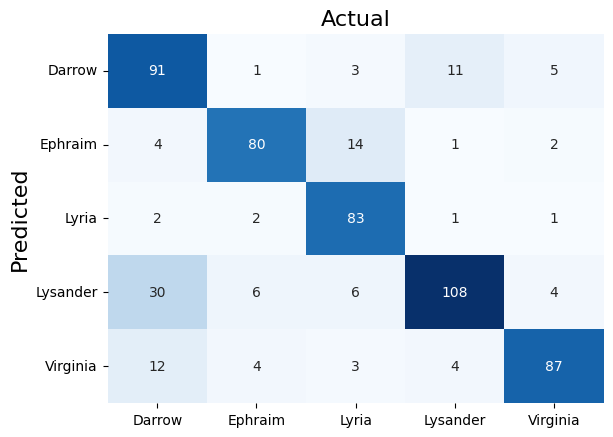

In [8]:
bert_cm = tf.math.confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(bert_model_ft.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]), axis=1),
)
classes = ['Darrow', 'Ephraim', 'Lyria', 'Lysander', 'Virginia']
sns.heatmap(bert_cm, annot=True, cbar=False, cmap="Blues", fmt="g", xticklabels=classes, yticklabels=classes)
plt.title('Actual', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.yticks(rotation=0)
plt.show()

The model performs very well at identifying the 'Ephraim' and 'Virginia' perspectives and performed modestly well on most of the others. Note that a large fraction (x/x) of 'Darrow' narrations were mistakenly attributed to 'Lysander'. This is likely due to intrinsic similarities between those two narrators as in the novel they fight against each other chapter to chapter. We can see that for the real 'Lysander' narratives, the 'Darrow' narrator was the most falsely predicted.

In [9]:
from sklearn.metrics import classification_report

print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(bert_model_ft.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]), axis=1),
    )
)

18/18 [==============================] - 28s 2s/step
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       111
           1       0.86      0.79      0.82       101
           2       0.76      0.93      0.84        89
           3       0.86      0.70      0.77       154
           4       0.88      0.79      0.83       110

    accuracy                           0.79       565
   macro avg       0.80      0.81      0.80       565
weighted avg       0.81      0.79      0.80       565



## Analysis of Out-of-Context Words

Here is the cosine_similarities method from class to calculate and print out the distances between given word embeddings.

In [10]:
def cosine_similarities(vecs):
    for v_1 in vecs:
        similarities = ''
        for v_2 in vecs:
            similarities += ('\t' + str(np.dot(v_1, v_2)/np.sqrt(np.dot(v_1, v_1) * np.dot(v_2, v_2)))[:4])
        print(similarities)

In the novel, the 'Red' caste (color) comprises the lowest socio-economic rung on the latter - they are slaves. Did the model learn about that?

The pre-trained embedding for 'slave' is quite similar to the post-tuning embedding for 'Red'!

In [11]:
enc_1 = bert_tokenizer("slave", return_tensors='tf')
enc_2 = bert_tokenizer("Red", return_tensors='tf')

#Vector representation for "slave" in pre-trained model
pt_1 = bert_model(enc_1)[0][0, 1].numpy()
#Vector representation for "Red" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][0, 1].numpy()

cosine_similarities([pt_1, ft_1])

	1.0	0.80
	0.80	1.0


On the other hand, the 'Gold' caste (color) rule and exploit other colors.

The cosine-similarity is much lower for the learned embedding for 'Gold' than 'Red' to 'slave'.

In [12]:
enc_1 = bert_tokenizer("slave", return_tensors='tf')
enc_2 = bert_tokenizer("Gold", return_tensors='tf')

#Vector representation for "slave" in pre-trained model
pt_1 = bert_model(enc_1)[0][0, 1].numpy()
#Vector representation for "Gold" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][0, 1].numpy()

cosine_similarities([pt_1, ft_1])

	1.0	0.65
	0.65	1.0


In the novel, Virginia is the Sovereign (ruler) of the Republic. Did the model learn about that?

The pre-trained embedding for 'Sovereign' is quite different to the post-tuning embedding for 'Virginia'.

In [13]:
enc_1 = bert_tokenizer("Sovereign", return_tensors='tf')
enc_2 = bert_tokenizer("Virginia", return_tensors='tf')

#Vector representation for "slave" in pre-trained model
pt_1 = bert_model(enc_1)[0][0, 1].numpy()
#Vector representation for "Red" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][0, 1].numpy()

cosine_similarities([pt_1, ft_1])

	1.0	0.34
	0.34	1.0


However, the post-tuning embedding for 'Sovereign' is much more similar to the post-tuning embedding for 'Virginia'. The model learned something!

In [14]:
enc_1 = bert_tokenizer("Sovereign", return_tensors='tf')
enc_2 = bert_tokenizer("Virginia", return_tensors='tf')

#Vector representation for "slave" in pre-trained model
pt_1 = bert_model_ft.layers[3](enc_1)[0][0, 1].numpy()
#Vector representation for "Red" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][0, 1].numpy()

cosine_similarities([pt_1, ft_1])

	1.0	0.63
	0.63	1.0
